# Conversion en Cirq

In [1]:
import cirq
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [ ]:
# exemple de val
"""q=2 #nombre de noeuds
P_i   = [4,6]          
c_i   = [10,5]       # coût par noeud
D_i   = [3,3]        # demande par noeud
D_tot=np.sum(D_i)
B_ij = {(0,1): 1.0 } 

lam=100 #pénalité
P_ij={(0,1):5}"""

## Les valeurs des paramètres

In [2]:
q=3
P_i   = [5,10,0]        # puissance générée par le noeud  
c_i   = [15,5,0]       # coût par noeud
D_i   = [2,3,4]        # demande par noeud
D_tot=np.sum(D_i)
#lam=100 pénalité
P_ij={(0,1):6, (1,2): 6, (0,2):4} #flux entre deux noeuds

B_ij={(0,1):1, (1,2):1, (0,2):1}

## Définition des variables binaires

En raison de la limite au niveau du nombre de qubits, on élimine les contraintes d'inégalité dans le cas du réseau à 3 noeuds:

In [4]:
liste = list(range(q))


x_vars = [(i, j) for i in range(q) for j in range(i+1, q)]
beta_vars = [(i, m) for i in liste for m in range(9)] 

"""c_vars = [
    (i, s)
    for i in liste
    for s in range(int(np.ceil(np.log2(P_i[i])))
)
]


c_vars = []
for i in liste:
    if P_i[i] > 0:
        for s in range(int(np.ceil(np.log2(P_i[i])))):
            c_vars.append((i, s))
    else:
        c_vars.append((i, 0))  # cas si P_i[i] == 0


# c_vars2=[(i,j,p) for i in liste for j in range(i+1, q) for p in range(int(np.ceil(np.log2(P_ij[(i,j)]+1))))]
c_vars2=[]
for i in liste:
    for j in range(i+1, q):
        if abs(P_ij[(i,j)])>0: 
            for p in range(int(np.ceil(np.log2(abs(P_ij[(i,j)]))))): c_vars2.append((i,j,p))
            
        else: c_vars2.append((i,j,0))
        
        
#c_vars3= [(i,j,p) for i in liste for j in range(i+1, q) for p in range(int(np.ceil(np.log2(P_ij[(i,j)]+1))))]
c_vars3=[]
for i in liste:
    for j in range(i+1, q):
        if abs(P_ij[(i,j)])>0: 
            for p in range(int(np.ceil(np.log2(abs(P_ij[(i,j)]))))): c_vars3.append((i,j,p))
            
        else: c_vars3.append((i,j,0)) """
        

all = x_vars + beta_vars #+ c_vars + c_vars2+ c_vars3
qubit_index = {f"x_{i}_{j}": idx for idx, (i,j) in enumerate(x_vars)}
offset = len(x_vars)
for k, (i,m) in enumerate(beta_vars):
    qubit_index[f"beta_{i}_{m}"] = offset + k
    
"""offset = len(x_vars) + len(beta_vars)
for k, (i, s) in enumerate(c_vars):
    qubit_index[f"c_{i}_{s}"] = offset + k
    
offset=len(x_vars) + len(beta_vars)+ len(c_vars)
for k, (i,j,p) in enumerate (c_vars2):
    qubit_index[f"c2_{i}_{j}_{p}"]=offset+k
    
offset=len(x_vars) + len(beta_vars)+ len(c_vars)+ len(c_vars3)
for k, (i,j,p) in enumerate (c_vars3):
    qubit_index[f"c3_{i}_{j}_{p}"]=offset+k"""


n_qubit = len(all)

print("le nombre de qubits est:", n_qubit)

le nombre de qubits est: 30


In [5]:
#Pour coder les index
def idx_x(i, j):
    return qubit_index[f"x_{i}_{j}"]

def idx_beta(i, s, m):
    return qubit_index[f"beta_{i}_{m}"]

def idx_c(i,r):
    return qubit_index[f"c_{i}_{r}"]

def idx_c2(i,j,p):
    return qubit_index[f"c2_{i}_{j}_{p}"]

def idx_c3(i,j,p):
    return qubit_index[f"c3_{i}_{j}_{p}"]

## Construction de H_c

In [6]:
terms = []
lam=1000
for i in range(q):
    for j in range(i+1, q):
        if (i,j) not in B_ij:
            continue
        Bij = B_ij[(i,j)]
        for m in range(5):  # nombre de "modes" alpha
            for s in range(m+1, 5):  # nombre de bits pour l'encodage binaire
                coeff = (1 / 4.0) * (2**s) * (lam + c_i[i]) * Bij * np.pi/180

                x_idx = idx_x(i, j)
                b_i_idx = idx_beta(i, s, m)
                b_j_idx = idx_beta(j, s, m)

                # - Z_x * Z_beta_j
                pauli_string = cirq.PauliString({
                    cirq.LineQubit(x_idx): cirq.Z,
                    cirq.LineQubit(b_j_idx): cirq.Z,
                })
                terms.append((pauli_string, -coeff))

                # + Z_x * Z_beta_i
                pauli_string = cirq.PauliString({
                    cirq.LineQubit(x_idx): cirq.Z,
                    cirq.LineQubit(b_i_idx): cirq.Z,
                })
                terms.append((pauli_string, coeff))

                # + Z_beta_j
                pauli_string = cirq.PauliString({
                    cirq.LineQubit(b_j_idx): cirq.Z,
                })
                terms.append((pauli_string, coeff))

                # - Z_beta_i
                pauli_string = cirq.PauliString({
                    cirq.LineQubit(b_i_idx): cirq.Z,
                })
                terms.append((pauli_string, -coeff))

# Afficher quelques termes
for term, coeff in terms[:5]:
    print(f"{term}: coeff={coeff}")

Z(q(0))*Z(q(12)): coeff=-8.857545953871222
Z(q(0))*Z(q(3)): coeff=8.857545953871222
Z(q(12)): coeff=8.857545953871222
Z(q(3)): coeff=-8.857545953871222
Z(q(0))*Z(q(12)): coeff=-17.715091907742444


In [8]:
for i in range(q):
    for j in range(i+1, q):
        const_term = -P_ij[(i,j)] + 2 * D_i[i] - P_i[i]
        pauli_string = cirq.PauliString()  # Identité (aucun opérateur sur aucun qubit)
        terms.append((pauli_string, const_term))


Je vais éliminer les contraintes d'inégalité afin de réduire le nombre de qubits.

In [66]:
"""for i in range(q):
    if P_i[i] > 0:
        ki = int(np.ceil(np.log2(P_i[i])))
    else:
        ki = 0
    for r in range(ki):
        c_idx = idx_c(i, r)
        coeff = 2**(r - 1)

        # CORRECTION : Utiliser PauliString avec coefficient
        identity_term = cirq.PauliString(coefficient=coeff)
        terms.append((identity_term, 1.0))  # Le coefficient est déjà dans PauliString

        # CORRECTION : Créer une vraie PauliString
        z_term = cirq.PauliString(cirq.Z(cirq.LineQubit(c_idx)), coefficient=-1.0)
        terms.append((z_term, coeff))"""
        
        



'for i in range(q):\n    if P_i[i] > 0:\n        ki = int(np.ceil(np.log2(P_i[i])))\n    else:\n        ki = 0\n    for r in range(ki):\n        c_idx = idx_c(i, r)\n        coeff = 2**(r - 1)\n\n        # CORRECTION : Utiliser PauliString avec coefficient\n        identity_term = cirq.PauliString(coefficient=coeff)\n        terms.append((identity_term, 1.0))  # Le coefficient est déjà dans PauliString\n\n        # CORRECTION : Créer une vraie PauliString\n        z_term = cirq.PauliString(cirq.Z(cirq.LineQubit(c_idx)), coefficient=-1.0)\n        terms.append((z_term, coeff))'

In [67]:
"""for i in range(q):
    for j in range(i+1, q):
        kij = int(np.ceil(np.log2(abs(P_ij[(i, j)])))) if abs(P_ij[(i, j)]) > 0 else 1

        for p in range(kij):
            c2_idx = idx_c2(i, j, p)  # index du qubit c2_{i,j,p}
            coeff = 2 ** (p - 1)

            # Terme identité (constante)
            identity_term = cirq.PauliString(coefficient=coeff)
            terms.append((identity_term, 1.0))
            # Terme Pauli Z
            z_term = cirq.PauliString(cirq.Z(cirq.LineQubit(c2_idx)), coefficient=-1.0)
            terms.append((z_term, coeff))"""
            
            
            


'for i in range(q):\n    for j in range(i+1, q):\n        kij = int(np.ceil(np.log2(abs(P_ij[(i, j)])))) if abs(P_ij[(i, j)]) > 0 else 1\n\n        for p in range(kij):\n            c2_idx = idx_c2(i, j, p)  # index du qubit c2_{i,j,p}\n            coeff = 2 ** (p - 1)\n\n            # Terme identité (constante)\n            identity_term = cirq.PauliString(coefficient=coeff)\n            terms.append((identity_term, 1.0))\n            # Terme Pauli Z\n            z_term = cirq.PauliString(cirq.Z(cirq.LineQubit(c2_idx)), coefficient=-1.0)\n            terms.append((z_term, coeff))'

In [68]:
"""for i in range(q):
    for j in range(i+1, q):
        kij = int(np.ceil(np.log2(abs(P_ij[(i, j)])))) if abs(P_ij[(i, j)]) > 0 else 1

        for p in range(kij):
            c3_idx = idx_c3(i, j, p)  # index du qubit c3_{i,j,p}
            coeff = 2 ** (p - 1)

            # Terme identité
            identity_term = cirq.PauliString(coefficient=coeff)
            terms.append((identity_term, 1.0))

            # Terme Z sur c3 qubit
            z_term = cirq.PauliString(cirq.Z(cirq.LineQubit(c2_idx)), coefficient=-1.0)
            terms.append((z_term, coeff))"""
            


'for i in range(q):\n    for j in range(i+1, q):\n        kij = int(np.ceil(np.log2(abs(P_ij[(i, j)])))) if abs(P_ij[(i, j)]) > 0 else 1\n\n        for p in range(kij):\n            c3_idx = idx_c3(i, j, p)  # index du qubit c3_{i,j,p}\n            coeff = 2 ** (p - 1)\n\n            # Terme identité\n            identity_term = cirq.PauliString(coefficient=coeff)\n            terms.append((identity_term, 1.0))\n\n            # Terme Z sur c3 qubit\n            z_term = cirq.PauliString(cirq.Z(cirq.LineQubit(c2_idx)), coefficient=-1.0)\n            terms.append((z_term, coeff))'

In [9]:
from functools import reduce
from operator import add

ops = []
for ps, coeff in terms:
    # ps est maintenant un cirq.PauliString
    ops.append(ps * coeff)    # * à droite

if ops:
    H_c = reduce(add, ops)
else:
    H_c = cirq.PauliString()


In [ ]:
"""from functools import reduce
from operator import add

# Créer la somme pondérée des PauliStrings → Hamiltonien
H_c = reduce(add, [coeff * ps for ps, coeff in terms])"""


## Construction de H_M

In [10]:
from functools import reduce
from operator import add

# H_M = somme des X_i pour tous les qubits
H_M_terms = [
    1.0 * cirq.PauliString({cirq.LineQubit(i): cirq.X})
    for i in range(n_qubit)
]

# Somme des PauliString → PauliSum
H_M = reduce(add, H_M_terms)

print("Hamiltonien de mélange H_M:")
print(H_M)


Hamiltonien de mélange H_M:
1.000*X(q(0))+1.000*X(q(1))+1.000*X(q(2))+1.000*X(q(3))+1.000*X(q(4))+1.000*X(q(5))+1.000*X(q(6))+1.000*X(q(7))+1.000*X(q(8))+1.000*X(q(9))+1.000*X(q(10))+1.000*X(q(11))+1.000*X(q(12))+1.000*X(q(13))+1.000*X(q(14))+1.000*X(q(15))+1.000*X(q(16))+1.000*X(q(17))+1.000*X(q(18))+1.000*X(q(19))+1.000*X(q(20))+1.000*X(q(21))+1.000*X(q(22))+1.000*X(q(23))+1.000*X(q(24))+1.000*X(q(25))+1.000*X(q(26))+1.000*X(q(27))+1.000*X(q(28))+1.000*X(q(29))


## Opérateurs d'évolution temporelle

In [11]:
def U_C(gamma, H):
    return cirq.PauliSumExponential(H, exponent=-1j * gamma)

def U_M(beta, H):
    return cirq.PauliSumExponential(H, exponent=-1j * beta)


## Construction du circuit QAOA

In [12]:
def build_qaoa_circuit(n, p, gammas, betas, cost_h, mixer_h):
    qubits = cirq.LineQubit.range(n)
    circuit = cirq.Circuit()

    # Préparation de l'état initial : superposition |+>^n
    circuit.append(cirq.H.on_each(*qubits))

    # Appliquer p couches de QAOA
    for layer in range(p):
        gamma = float(gammas[layer])
        beta = float(betas[layer])

        # Evolution sous Hamiltonien de coût
        circuit.append(cirq.PauliSumExponential(cost_h, exponent=-1j * gamma))

        # Evolution sous Hamiltonien de mélange
        circuit.append(cirq.PauliSumExponential(mixer_h, exponent=-1j * beta))

    return circuit


### Exemple de construction du circuit QAOA

In [13]:
# Construction du circuit QAOA (p=2 couches)
p = 2
g = [np.pi/4, np.pi/2, np.pi/6, np.pi/7, np.pi/10]
gammas = g[:p]
b = [np.pi/8, np.pi/4, np.pi/3, np.pi/8, np.pi/2]
betas = b[:p]

params = gammas + betas  # utile si tu veux optimiser plus tard

cost_h = H_c  # cirq.PauliSum construit précédemment
mixer_h = H_M

# Construction du circuit sans mesure
qc2 = build_qaoa_circuit(n_qubit, p, gammas, betas, cost_h, mixer_h)

# Ajout de la mesure
qubits = cirq.LineQubit.range(n_qubit)
qc2.append(cirq.measure(*qubits, key='result'))


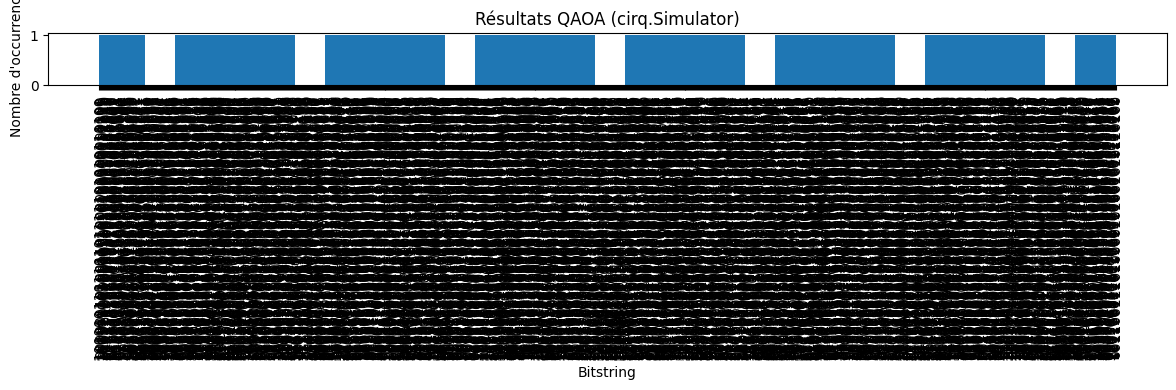

In [14]:
simulator = cirq.Simulator()
result = simulator.run(qc2, repetitions=1024)

import matplotlib.pyplot as plt

# Récupérer les résultats sous forme d'histogramme (entiers)
#hist = result.histogram(key='result', fold_func=bin)
from cirq import value

hist = result.histogram(
    key='result',
    fold_func=value.big_endian_bits_to_int
)
# Convertir clés entières en chaînes binaires
counts = {bin(k)[2:].zfill(n_qubit): v for k, v in hist.items()}

"""hist = result.histogram(key='result')  # donne des tuples comme (0,1,1,...)
counts = {
    ''.join(map(str, k)): v
    for k, v in hist.items()
}"""


# Afficher l'histogramme
plt.figure(figsize=(12, 4))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.title("Résultats QAOA (cirq.Simulator)")
plt.xlabel("Bitstring")
plt.ylabel("Nombre d'occurrences")
plt.tight_layout()
plt.show()


## Fonction objectif

In [15]:
def qaoa_expectation(params):
    gammas = params[:p]
    betas = params[p:]
    
    # Construire le circuit
    circuit = build_qaoa_circuit(n_qubit, p, gammas, betas, H_c, H_M)
    
    # Simuler
    result = simulator.simulate(circuit)
    
    # Calculer l'espérance
    expval = simulator.simulate_expectation_values(
        program=circuit,
        observables=[H_c],
        qubit_order=cirq.LineQubit.range(n_qubit)
    )[0]
    
    return np.real(expval)


##  Réseau à 2 noeuds

In [76]:
import time
import numpy as np
from scipy.optimize import minimize
import cirq
import matplotlib.pyplot as plt

simulator = cirq.Simulator()

start = time.time()
p=5
gammas = np.linspace(0, np.pi, p) 
betas = np.linspace(0, np.pi/2, p)
params = np.concatenate([gammas, betas]) # point de départ --> initialisation


# Optimisation des paramètres QAOA (gammas + betas)
result = minimize(qaoa_expectation, params, method='COBYLA')

print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", result.fun)

# Reconstruction du circuit avec les paramètres optimaux
gammas_opt = result.x[:p]
betas_opt = result.x[p:]
qc3 = build_qaoa_circuit(n_qubit, p, gammas_opt, betas_opt, cost_h, mixer_h)

# Ajout de la mesure sur tous les qubits
qubits = cirq.LineQubit.range(n_qubit)
qc3.append(cirq.measure(*qubits, key='result'))

# Simulation avec shots = 1024
result_new = simulator.run(qc3, repetitions=1024)

# Récupération et affichage des counts
hist = result_new.histogram(
    key='result',
    fold_func=lambda bits: ''.join(str(b) for b in bits)
)

# Ici counts_new est directement un dict "bitstring" -> fréquence
counts_new = dict(hist)


"""plt.figure(figsize=(12, 4))
plt.bar(counts_new.keys(), counts_new.values())
plt.xticks(rotation=90)
plt.title("Résultats QAOA avec paramètres optimaux (Cirq)")
plt.xlabel("Bitstring mesuré")
plt.ylabel("Nombre d'occurrences")
plt.tight_layout()
plt.show()"""

end = time.time()
print("Temps d'exécution :", end - start, "secondes")


Paramètres optimaux : [1.         0.78539816 1.57079633 2.35619449 3.14159265 0.
 0.39269908 0.78539816 1.17809725 1.57079633]
Espérance d'énergie minimale : -2.9999994598576794
Temps d'exécution : 177.23783922195435 secondes


## Réseau à 3 noeuds

In [16]:
import time
import numpy as np
from scipy.optimize import minimize
import cirq
import matplotlib.pyplot as plt

simulator = cirq.Simulator()

start = time.time()
p=2
gammas = np.linspace(0, np.pi, p) 
betas = np.linspace(0, np.pi/2, p)
params = np.concatenate([gammas, betas]) # point de départ --> initialisation


# Optimisation des paramètres QAOA (gammas + betas)
result = minimize(qaoa_expectation, params, method='COBYLA')

print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", result.fun)

# Reconstruction du circuit avec les paramètres optimaux
gammas_opt = result.x[:p]
betas_opt = result.x[p:]
qc3 = build_qaoa_circuit(n_qubit, p, gammas_opt, betas_opt, cost_h, mixer_h)

# Ajout de la mesure sur tous les qubits
qubits = cirq.LineQubit.range(n_qubit)
qc3.append(cirq.measure(*qubits, key='result'))

# Simulation avec shots = 1024
result_new = simulator.run(qc3, repetitions=1024)

# Récupération et affichage des counts
hist = result_new.histogram(
    key='result',
    fold_func=lambda bits: ''.join(str(b) for b in bits)
)

# Ici counts_new est directement un dict "bitstring" -> fréquence
counts_new = dict(hist)


"""plt.figure(figsize=(12, 4))
plt.bar(counts_new.keys(), counts_new.values())
plt.xticks(rotation=90)
plt.title("Résultats QAOA avec paramètres optimaux (Cirq)")
plt.xlabel("Bitstring mesuré")
plt.ylabel("Nombre d'occurrences")
plt.tight_layout()
plt.show()"""

end = time.time()
print("Temps d'exécution :", end - start, "secondes")


Paramètres optimaux : [-1.00000000e-04  3.14159265e+00  0.00000000e+00  1.57079633e+00]
Espérance d'énergie minimale : -10.999998284260474
Temps d'exécution : 5803.576961278915 secondes


In [17]:
# Récupérer le bitstring le plus probable après exécution P=2
best_bitstring = max(counts_new, key=counts_new.get)
print("Bitstring le plus probable :", best_bitstring)
print("Nombre d'occurrences :", counts_new[best_bitstring])

Bitstring le plus probable : 000001110011001011010100000010
Nombre d'occurrences : 1


In [82]:
from collections import Counter

print("Top résultats QAOA:")
for bitstring, freq in Counter(counts_new).most_common(20):
    print(f"{bitstring} : {freq} fois")
print("Résultats de mesure :", counts_new)

Top résultats QAOA:
000001110011001011010100000010 : 1 fois
000110011100101101100100010011 : 1 fois
110111000001011101000101000010 : 1 fois
101100111001000010101101011101 : 1 fois
100000011011110110011001110110 : 1 fois
100100011111011010110001101110 : 1 fois
010011001100100010010011000100 : 1 fois
101001101110001011000111110001 : 1 fois
010000100111001011100110011111 : 1 fois
100011000101000110010100111001 : 1 fois
000101101100101000001000111000 : 1 fois
010010000100000111000011001011 : 1 fois
000011011100001010110000011111 : 1 fois
111011101100000110001100110000 : 1 fois
011000010001111110001001001100 : 1 fois
100010001101001000100010010101 : 1 fois
000011110110011010110111000011 : 1 fois
111000110100101101000010000011 : 1 fois
011101011110111111110100010100 : 1 fois
111011011111100111001000000001 : 1 fois
Résultats de mesure : {'000001110011001011010100000010': 1, '000110011100101101100100010011': 1, '110111000001011101000101000010': 1, '101100111001000010101101011101': 1, '10000001

In [106]:
best_bitstring="010010000100000111000011001011"

In [107]:
# Pour retourner les bits correspondant à une variable donnée dans le dictionnaire considéré au début

inv_index = {v: k for k, v in qubit_index.items()} # j'inverse le dict

bit_values = {}
for i, bit in enumerate(best_bitstring):
    var_name = inv_index[i]
    bit_values[var_name] = int(bit)
x_values = {k: v for k, v in bit_values.items() if k.startswith("x_")}
beta_values = {k: v for k, v in bit_values.items() if k.startswith("beta_")}

for var_group, values in [("x_vars", x_values), ("beta_vars", beta_values)]:
    print(f"{var_group}:")
    for var, val in sorted(values.items()):
        print(f"  {var} = {val}")

x_vars:
  x_0_1 = 0
  x_0_2 = 1
  x_1_2 = 0
beta_vars:
  beta_0_0 = 0
  beta_0_1 = 1
  beta_0_2 = 0
  beta_0_3 = 0
  beta_0_4 = 0
  beta_0_5 = 0
  beta_0_6 = 1
  beta_0_7 = 0
  beta_0_8 = 0
  beta_1_0 = 0
  beta_1_1 = 0
  beta_1_2 = 0
  beta_1_3 = 1
  beta_1_4 = 1
  beta_1_5 = 1
  beta_1_6 = 0
  beta_1_7 = 0
  beta_1_8 = 0
  beta_2_0 = 0
  beta_2_1 = 1
  beta_2_2 = 1
  beta_2_3 = 0
  beta_2_4 = 0
  beta_2_5 = 1
  beta_2_6 = 0
  beta_2_7 = 1
  beta_2_8 = 1


In [108]:
# Pour calculer \sum_{m} (beta(i,m)-beta-(j,m)).2^m
def compute_difference(i, j, beta_values, max_m=8):
    total = 0
    for m in range(max_m + 1):
        beta_i = beta_values.get(f"beta_{i}_{m}", 0)
        beta_j = beta_values.get(f"beta_{j}_{m}", 0)
        total += (beta_i - beta_j) * (2 ** m)
    return total

diff_0_1 = compute_difference(0, 1, beta_values)
diff_0_2=  compute_difference(0, 2, beta_values)
diff_1_2=  compute_difference(1, 2, beta_values)

print("S(0,1) =", diff_0_1)
print("S(0,2) =", diff_0_2)
print("S(1,2) =", diff_1_2)


S(0,1) = 10
S(0,2) = -356
S(1,2) = -366


In [109]:
# Pour calculer le flux entre deux noeuds donnés
def compute_S(i, j, beta_values, max_m=8):
    total = 0
    for m in range(max_m + 1):
        beta_i = beta_values.get(f"beta_{i}_{m}", 0)
        beta_j = beta_values.get(f"beta_{j}_{m}", 0)
        total += (beta_i - beta_j) * (2 ** m)
    return total

def compute_expression(i, j, beta_values, x_values, max_m=8):
    S_ij = compute_S(i, j, beta_values, max_m)
    x_ij = x_values.get(f"x_{i}_{j}", 0)
    return S_ij * (np.pi / 180) * x_ij

result1 = compute_expression(0, 1, beta_values, x_values)
result2 = compute_expression(0, 2, beta_values, x_values)
result3 = compute_expression(1, 2, beta_values, x_values)

print("l_0_1 =", result1)
print("l_0_2 =", result2)
print("l_1_2 =", result3)


l_0_1 = 0.0
l_0_2 = -6.213372137099813
l_1_2 = -0.0


In [110]:
# On déduit la puissance générée par les noeuds
g0=D_i[0]+result1+result2
g1=D_i[1]+result3-result1
g2=D_i[2]-result2-result3

print("g0=", g0)
print("g1=", g1)
print("g2=", g2)

g0= -4.213372137099813
g1= 3.0
g2= 10.213372137099814


In [111]:
c=g0*c_i[0]+g1*c_i[1]+g2*c_i[2]
ratio=c/45
print("le cout:",c)
print("le ratio:", ratio)

le cout: -48.2005820564972
le ratio: -1.0711240456999378


## Analyse des résultats: Réseau à 2 noeuds

In [ ]:
# Récupérer le bitstring le plus probable après exécution P=2
best_bitstring = max(counts_new, key=counts_new.get)
print("Bitstring le plus probable :", best_bitstring)
print("Nombre d'occurrences :", counts_new[best_bitstring])


Bitstring le plus probable : 1101100000110000010
Nombre d'occurrences : 1


In [61]:
# Récupérer le bitstring le plus probable après exécution P=5
best_bitstring = max(counts_new, key=counts_new.get)
print("Bitstring le plus probable :", best_bitstring)
print("Nombre d'occurrences :", counts_new[best_bitstring])


Bitstring le plus probable : 1111100100001100001
Nombre d'occurrences : 2


In [ ]:
best_bitstring='1110110100011110010' 


### Décodage

In [79]:
# Pour retourner les bits correspondant à une variable donnée dans le dictionnaire considéré au début

inv_index = {v: k for k, v in qubit_index.items()} # j'inverse le dict

bit_values = {}
for i, bit in enumerate(best_bitstring):
    var_name = inv_index[i]
    bit_values[var_name] = int(bit)



In [80]:
x_values = {k: v for k, v in bit_values.items() if k.startswith("x_")}
beta_values = {k: v for k, v in bit_values.items() if k.startswith("beta_")}

for var_group, values in [("x_vars", x_values), ("beta_vars", beta_values)]:
    print(f"{var_group}:")
    for var, val in sorted(values.items()):
        print(f"  {var} = {val}")
        
    


x_vars:
  x_0_1 = 1
beta_vars:
  beta_0_0 = 1
  beta_0_1 = 1
  beta_0_2 = 0
  beta_0_3 = 1
  beta_0_4 = 1
  beta_0_5 = 0
  beta_0_6 = 1
  beta_0_7 = 0
  beta_0_8 = 0
  beta_1_0 = 0
  beta_1_1 = 1
  beta_1_2 = 1
  beta_1_3 = 1
  beta_1_4 = 1
  beta_1_5 = 0
  beta_1_6 = 0
  beta_1_7 = 1
  beta_1_8 = 0
